In [1]:
import os, sys
import matplotlib.pyplot as plt

from timeit import timeit

# import numpy as np
import jax.numpy as np
from jax import grad, jit

from classy import Class
from pybird.correlator import Correlator

/cluster/home/pizhang/.local/lib/python3.10/site-packages/jaxtyping/__init__.py:226: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


dev mode, reload the following: 

In [2]:
import importlib, pybird
importlib.reload(pybird.correlator)
from pybird.correlator import Correlator

# Testing jax

### Linear cosmology

In [3]:
z = .5

In [4]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': z})
M.compute()

In [5]:
kk = np.logspace(-5, 1, 300)
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) 

from scipy.interpolate import interp1d
ipk_lin = interp1d(kk, pk_lin, kind='cubic')

D1, f1 = M.scale_independent_growth_factor(z), M.scale_independent_growth_factor_f(z), 
A_s, Omega0_m = 1e-10 * np.exp(cosmo['ln10^{10}A_s']), M.Omega0_m()

H_ap, D_ap = M.Hubble(z) / M.Hubble(0.), M.angular_distance(z) * M.Hubble(0.)

cosmo_lin = {'kk': kk, 'pk_lin': pk_lin, 'f': f1, 'H': H_ap, 'DA': D_ap} # 'D': D1, 'z': z, 'Omega0_m': Omega0_m}

### Testing special functions written to be jax-compatible

Legendre polynomials

In [6]:
from scipy.special import legendre as legendre_
from pybird.jax_special import legendre

In [7]:
a = np.array([[0.1, 0.2],[0.3, 0.5]])
b = np.array([0.6, 0.8, -0.35])
print ( legendre_(2)(a) )
print ( legendre(2)(a) )

[[-0.485      -0.44      ]
 [-0.36499999 -0.125     ]]
[[-0.485 -0.44 ]
 [-0.365 -0.125]]


In [8]:
n = 4

def time_legendre(): legendre_(n)(a)
print ('%.5f sec' % timeit(stmt=time_legendre, number=100))

def time_jax_legendre(): legendre(n)(a)
print ('%.5f sec' % timeit(stmt=time_jax_legendre, number=100))

jit_legendre = jit(legendre(n))
init = jit_legendre(a)
def time_jit_legendre(): jit_legendre(a)
print ('%.5f sec' % timeit(stmt=time_jit_legendre, number=100))

0.02311 sec
0.08616 sec
0.00056 sec


interpolation

In [9]:
from scipy.interpolate import interp1d as interp1d_
from pybird.jax_special import interp1d

In [10]:
pk_many = np.array([(1+i) * pk_lin for i in range(3)])
pk_scipy = interp1d_(kk, pk_many, kind='cubic', axis=-1)(kk)
pk_jax = interp1d(kk, pk_many, kind='cubic', axis=-1)(kk)

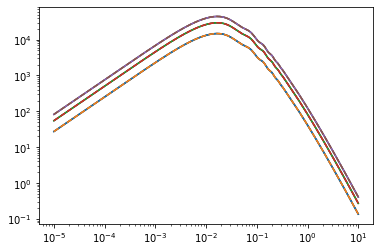

In [11]:
for i in range(3): 
    plt.plot(kk, pk_many[i], 'k')
    plt.plot(kk, pk_scipy[i], '-')
    plt.plot(kk, pk_jax[i], '--')
plt.xscale('log')
plt.yscale('log')
plt.show()

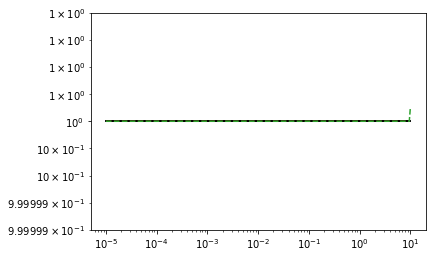

In [12]:
for i in range(3): 
    plt.plot(kk, pk_scipy[i]/pk_many[i], 'k')
    plt.plot(kk, pk_jax[i]/pk_many[i], '--')

plt.ylim(1-1e-6, 1+1e-6)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [13]:
def time_interp1d(): interp1d_(kk, pk_many, kind='cubic', axis=-1)(kk)
print ('%.5f sec' % timeit(stmt=time_interp1d, number=100))

def time_jax_interp1d(): interp1d(kk, pk_many, kind='cubic', axis=-1)(kk)
print ('%.5f sec' % timeit(stmt=time_jax_interp1d, number=100))

jit_interp1d = jit(interp1d(kk, pk_many, kind='cubic', axis=-1))
init = jit_interp1d(kk)
def time_jit_interp1d(): jit_interp1d(kk)
print ('%.5f sec' % timeit(stmt=time_jit_interp1d, number=100))

0.04387 sec
0.03473 sec
0.00293 sec


### FFTLog in jax

In [14]:
from pybird.fftlog import FFTLog
importlib.reload(pybird.fftlog)
from pybird.fftlog import FFTLog

In [15]:
fftsettings = dict(Nmax=256, xmin=1e-5, xmax=1e3, bias=-0.01, window=0.2)
fft = FFTLog(**fftsettings)

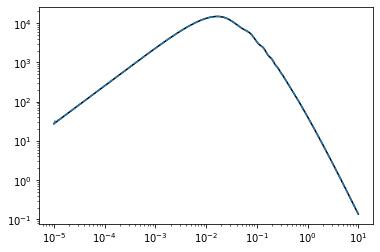

In [16]:
pk_rec = fft.sumCoefxPow(kk, pk_lin, kk) 

plt.plot(kk, pk_lin, 'k')
# plt.plot(kk, pk_rec_0, '--')
plt.plot(kk, pk_rec, '--')

plt.xscale('log')
plt.yscale('log')
plt.show()

jax, but no jit

In [17]:
def time_Coef(): fft.Coef(kk, pk_lin)
print ('%.3f sec' % timeit(stmt=time_Coef, number=100))

0.454 sec


jax with jit

In [18]:
jit_Coef = jit(fft.Coef)
init = jit_Coef(kk, pk_lin)
def time_jit_Coef(): jit_Coef(kk, pk_lin)
print ('%.3f sec' % timeit(stmt=time_jit_Coef, number=100))

0.002 sec


let's go!

### PyBird benchmark

Loading some fiducial EFT parameters for testing

In [19]:
outdir = os.path.join(os.path.expanduser('~'), 'share', 'pybird', 'data', 'eftboss', 'out')
with open(os.path.join(outdir, 'fit_boss_onesky_pk_wc_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_params = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}
print (eft_params)

{'b1': 1.9536, 'c2': 0.5865, 'c4': 0.0, 'b3': -0.3595, 'cct': 0.1821, 'cr1': -0.8417, 'cr2': -0.808, 'ce0': 1.4954, 'ce1': 0.0, 'ce2': -1.6292, 'b2': 0.4147, 'b4': 0.4147}


Setting PyBird correlator class

In [20]:
import importlib, pybird
importlib.reload(pybird.correlator)
from pybird.correlator import Correlator

In [31]:
dk = 0.01
k0 = np.arange(0.01, 0.3, dk)

In [32]:
N = Correlator()

N.set({'output': 'bPk', 'multipole': 2, 'kmax': 0.3, 
       'with_resum': False, # 'with_bias': True, 
       'km': 0.7, 'kr': 0.35, 'nd': 3e-4, 
       # 'with_ap': True, 'H_fid': H_ap * 1.01, 'D_fid': D_ap * 1.01,
       'xdata': k0, 
       'with_binning': True, 'binsize': dk,
       'eft_basis': 'eftoflss', 'with_stoch': True}) 

# cosmo_lin.update({'bias': eft_params})

internal PyBird k array on which the predictions is computed (as we do not specify option `'xdata'`)

Computation

In [33]:
N.compute(cosmo_lin) 
bpk_0 = N.get(eft_params) 

In [34]:
# N.nonlinear.PsCf(N.bird)

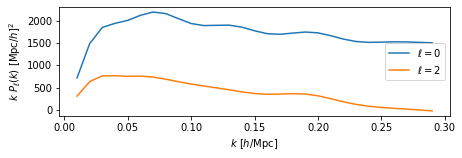

In [35]:
plt.figure(figsize=(7,2))
for i in range(2): plt.plot(k0, k0 * bpk_0[i], label=r'$\ell=%s$' % (2*i))
plt.xlabel(r'$k \ [h/{\rm Mpc}]$')
plt.ylabel(r'$k \ P_\ell(k) \ [{\rm Mpc}/h]^2$')
plt.legend()
plt.show()

### jit?

In [36]:
# def time_compute(): N.compute(cosmo_lin) 
# print ('%.3f sec' % timeit(stmt=time_compute, number=10))

In [37]:
N.compute(cosmo_lin, init_jit=True) 

In [40]:
def time_jit_compute(): N.compute(cosmo_lin, is_jit=True) 
print ('%.3f sec' % timeit(stmt=time_jit_compute, number=100)) 

0.068 sec


Let's go!